# Baseline dice score

In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
def dice_score(baseline_seg, gt_seg, target_class):
    """
    Compute the Dice score for a specific class.
    
    Parameters:
    - res_seg: np.array, predicted segmentation
    - gt_seg: np.array, ground truth segmentation
    - target_class: int, the class for which the Dice score is computed
    
    Returns:
    - dice: float, Dice score for the target class
    """
    # Create binary masks for the target class
    baseline_mask = (baseline_seg == target_class)
    gt_mask = (gt_seg == target_class)
    
    # Compute intersection and union
    intersection = np.sum(baseline_mask & gt_mask)
    total_pixels = np.sum(baseline_mask) + np.sum(gt_mask)
    
    # Compute Dice score
    if total_pixels == 0:  # Avoid division by zero
        print('it is zero')
        return 1.0 if np.sum(gt_mask) == 0 else 0.0
    
    dice = (2 * intersection) / total_pixels
    return dice


In [3]:
%%capture
# Import from different folder
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_preprocess_dir = os.path.join(parent_dir, "DataPreprocess")

sys.path.append(data_preprocess_dir)
from main_preprocess import load_nifti_convert_to_numpy

In [4]:
# Define paths
data_path = '/Users/bruger/Desktop/Bachelor/resampled_lung_pilot_data'
cropped_lung_ct_path = data_path + '/cropped_lungs_ct/*.nii.gz'
cropped_lung_ct_paths = glob.glob(cropped_lung_ct_path)

cropped_lung_gt_path = data_path + '/cropped_lungs_gt/*.nii.gz'
cropped_lung_gt_paths = glob.glob(cropped_lung_gt_path)

output_dir = data_path + "/numpy_files/"

In [5]:
# # Make attenuation and baseline seg arrays
# rows = []
# for path in cropped_lung_ct_paths:
#     arr = load_nifti_convert_to_numpy(input_path=path).flatten()
#     baseline_seg = np.where(
#     arr == -10000, 0,  # If the value is -10000, classify as 0
#     np.where(
#         (arr >= -720) & (arr <= -300), 2,  # If within the range [-720, -300], classify as 2
#         1  # Otherwise, classify as 1
#     )
# )
#     patient_id = os.path.basename(path)[7:10]

#     np.save(os.path.join(output_dir, f"patient_{patient_id}_attenuation.npy"), arr)
#     np.save(os.path.join(output_dir, f"patient_{patient_id}_baseline_seg.npy"), baseline_seg)

#     new_row = {
#         'attenuation': arr,
#         'res_seg': baseline_seg,
#         'patient': patient_id,
#         'label': 'w_ggo' if int(patient_id) < 14 else 'wo_ggo',
#     }
#     rows.append(new_row)

In [10]:
# # Make GT seg
# gt_rows = []
# for path in cropped_lung_gt_paths:
#     patient_id = os.path.basename(path)[7:10]
#     output_file = os.path.join(output_dir, f"patient_{patient_id}_gt_seg.npy")
    
#     # Check if the output file already exists
#     if os.path.exists(output_file):
#         print(f"Output file for patient {patient_id} already exists. Skipping...")
#         continue
    
#     # Process the file and save it
#     gt_seg = load_nifti_convert_to_numpy(input_path=path).flatten()
#     np.save(output_file, gt_seg)
    
#     # Prepare the metadata
#     new_gt_row = {
#         'gt_seg': gt_seg,
#         'patient': patient_id,
#         'label': 'w_ggo' if int(patient_id) < 14 else 'wo_ggo',
#     }
#     print(patient_id)
#     gt_rows.append(new_gt_row)


In [7]:
# # Directory containing the numpy files
# data_dir = output_dir

# target_class = 2

# dice_score(baseline_seg=row['baseline_seg'], gt_seg=row['gt_seg'], target_class=target_class)

# # Initialize a dictionary to store data
# data = {'patient_id': [], 'baseline_seg': [], 'gt_seg': []}

# # Loop through all files in the directory
# for file in os.listdir(data_dir):
#     print('new')
#     if file.endswith('.npy'):
#         # Extract patient ID and type of file from the filename
#         parts = file.split('_')
#         patient_id = parts[1]  # Assuming format is 'patient_XXX_...'
#         file_type = parts[2].split('.')[0]  # Extract 'baseline', or 'gt_seg'
#         if file_type == 'attenuation':
#             continue

#         # Load the numpy file
#         file_path = os.path.join(data_dir, file)
#         data_array = np.load(file_path)

#         # Check if patient_id is already in data
#         if patient_id not in data['patient_id']:
#             data['patient_id'].append(patient_id)
#             data['baseline_seg'].append(None)
#             data['gt_seg'].append(None)

#         # Update the respective field based on the file type
#         idx = data['patient_id'].index(patient_id)
#         if file_type == 'baseline':
#             data['baseline_seg'][idx] = data_array
#         elif file_type == 'gt':
#             data['gt_seg'][idx] = data_array
#         print(patient_id, file_type)

# # Convert the dictionary to a pandas DataFrame
# df = pd.DataFrame(data).sort_values('patient_id')
# df = df.reset_index(drop=True)

# # Display the DataFrame
# print(df)


In [12]:
# Directory containing the numpy files
data_dir = output_dir

# Initialize a list to store results
dice_scores = []

# Loop through all patient IDs
processed_patients = set()

for file in os.listdir(data_dir):
    if not file.endswith('.npy'):
        continue

    # Extract patient ID and type of file from the filename
    parts = file.split('_')
    patient_id = parts[1]  # Assuming format is 'patient_XXX_...'
    file_type = parts[2].split('.')[0]  # Extract 'baseline', or 'gt_seg'

    # Skip if attenuation file
    if file_type == 'attenuation':
        continue

    # Load the current file
    file_path = os.path.join(data_dir, file)
    data_array = np.load(file_path)

    # Check if the patient has already been processed
    if patient_id in processed_patients:
        continue
    print(f'Patient {patient_id}')

    # Try to find the corresponding baseline and gt files
    baseline_file = f'patient_{patient_id}_baseline_seg.npy'
    gt_file = f'patient_{patient_id}_gt_seg.npy'

    baseline_path = os.path.join(data_dir, baseline_file)
    gt_path = os.path.join(data_dir, gt_file)

    # Check if both files exist
    if os.path.exists(baseline_path) and os.path.exists(gt_path):
        # Load both arrays
        baseline_seg = np.load(baseline_path)
        gt_seg = np.load(gt_path)

        print(f'Number of pixels: {len(baseline_seg)}')
        print(f'Number in range: {np.sum(baseline_seg)}')
        print(f'Number of GT: {np.sum(gt_seg == 2)}')

        # Calculate Dice score for the target class
        target_class = 2
        dice = dice_score(baseline_seg, gt_seg, target_class)

        # Append results to the list
        dice_scores.append({'patient_id': patient_id, 'dice_score': dice})

        print(f"Processed patient {patient_id} with Dice score: {dice}")
    else:
        print("Failed for patient {patient_id}")

    # Mark the patient as processed
    processed_patients.add(patient_id)
    print('\n')

Patient 013
Number of pixels: 375193600
Number in range: 31742434
Number of GT: 748223
Processed patient 013 with Dice score: 0.2997196573719175


Patient 008
Number of pixels: 317849600
Number in range: 36618363
Number of GT: 16604
Processed patient 008 with Dice score: 0.010788767829666902


Patient 002
Number of pixels: 401817600
Number in range: 49554724
Number of GT: 1730807
Processed patient 002 with Dice score: 0.42372906768016305


Patient 003
Number of pixels: 469108736
Number in range: 29824495
Number of GT: 232599
Processed patient 003 with Dice score: 0.10679753629972495


Patient 007
Number of pixels: 373145600
Number in range: 40092035
Number of GT: 590344
Processed patient 007 with Dice score: 0.23598293678323226


Patient 009
Number of pixels: 395673600
Number in range: 53160622
Number of GT: 16316
Processed patient 009 with Dice score: 0.008746279105795347


Patient 011
Number of pixels: 523505600
Number in range: 37281299
Number of GT: 528838
Processed patient 011 wit

In [65]:
# Convert results to a DataFrame
df_dice = pd.DataFrame(dice_scores).sort_values('patient_id')
df_dice = df_dice.reset_index(drop=True)

# Display the DataFrame
print(df_dice)

# Optionally, save results to a CSV file
df_dice.to_csv(os.path.join(data_dir, 'dice_scores.csv'), index=False)


   patient_id  dice_score
0         000    0.675654
1         001    0.072225
2         002    0.423729
3         003    0.106798
4         004    0.041028
5         005    0.000959
6         006    0.020257
7         007    0.235983
8         008    0.010789
9         009    0.008746
10        010    0.417471
11        011    0.178908
12        012    0.155925
13        013    0.299720
14        014    0.000000


In [66]:
dice_nnunet = np.array([0.3315690926636748, 0.1567508583946277,  0.761951797033869, 0.4591240184358507, 0.12846373285736254, 0.0, 0.058878418284691245,  0.07678402840654613, 0.16263498549281508, 0.041703343893998955, 0.7008237710630416, 0.5342373217747566, 0.58440281538405, 0.36033640746538564, 0.0])

In [67]:
df_dice['dice_nnunet'] = dice_nnunet

In [68]:
df_dice = df_dice.drop(14)
df_dice = df_dice.drop(10)

In [69]:
df_dice

,patient_id,dice_score,dice_nnunet
0,000,0.675654,0.331569
1,001,0.072225,0.156751
2,002,0.423729,0.761952
3,003,0.106798,0.459124
4,004,0.041028,0.128464
5,005,0.000959,0.000000
6,006,0.020257,0.058878
7,007,0.235983,0.076784
8,008,0.010789,0.162635
9,009,0.008746,0.041703


/var/folders/j2/9f4vw4v96p97ssvk4f1301sw0000gn/T/ipykernel_72076/2103381976.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


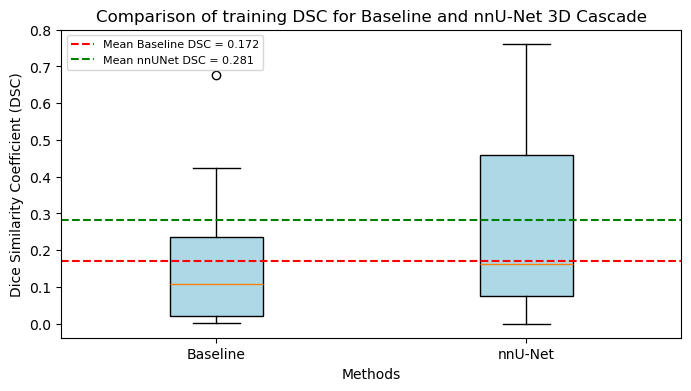

In [72]:
mean_dice = np.mean(df_dice['dice_score'])
mean_dice_nnunet = np.mean(df_dice['dice_nnunet'])

# Create the boxplots
plt.figure(figsize=(8, 4))
plt.boxplot(
    [df_dice['dice_score'], df_dice['dice_nnunet']],
    vert=True,
    patch_artist=True,
    widths=0.3,
    boxprops=dict(facecolor='lightblue'),
    labels=["Baseline", "nnU-Net"]
)

# Add mean lines for both
plt.axhline(y=mean_dice, color='red', linestyle='--', label=f'Mean Baseline DSC = {mean_dice:.3f}')
plt.axhline(y=mean_dice_nnunet, color='green', linestyle='--', label=f'Mean nnUNet DSC = {mean_dice_nnunet:.3f}')

# Add title and labels
plt.title('Comparison of training DSC for Baseline and nnU-Net 3D Cascade')
plt.ylabel('Dice Similarity Coefficient (DSC)')
plt.xlabel('Methods')

# Add legend
plt.legend(fontsize=8)

# Show the plot
plt.show()